## Ejercicios de pair programming 31 enero: Random Forest

In [1]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd
from tqdm import tqdm

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score , cohen_kappa_score, roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

In [12]:
df = pd.read_csv("card_transdata_balanceado.csv", index_col = 0)
df.head(2)

,repeat_retailer,used_chip,used_pin_number,online_order,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,fraud
995934,0,0,0,1,-0.398964,-0.176219,-0.493696,0
665555,1,0,0,1,-0.123435,-0.143533,0.579227,0


In [13]:
# separamos los datos en X e y
X1 = df.drop("fraud", axis = 1)
y1 = df["fraud"]

In [14]:
# separamos en train y test
x_train, x_test, y_train, y_test = train_test_split(X1, y1, test_size = 0.2, random_state = 42)

In [46]:
# Vamos a utilizar los mismos valores de profundidad y features que en el random forest ya que como tenemos muchos datos si probamos con más nos tarda mucho tiempo.
param = {"max_depth": [4], 
        "max_features": [1],
        "min_samples_split": [0.01], # Decidimos probar con un datos de samples más pequeños para intentar mejorar los resultados ya que con los mismos del desion tree no eran muy buenos resultados
        "min_samples_leaf": [0.01]} 

In [47]:
gs_rf = GridSearchCV(
            estimator=RandomForestClassifier(random_state=42),
            param_grid= param, 
            cv=10, 
            verbose=-1) 
        

In [48]:
gs_rf.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [4], 'max_features': [1],
                         'min_samples_leaf': [0.01],
                         'min_samples_split': [0.01]},
             verbose=-1)

In [49]:
bosque = gs_rf.best_estimator_
bosque

RandomForestClassifier(max_depth=4, max_features=1, min_samples_leaf=0.01,
                       min_samples_split=0.01, random_state=42)

In [58]:
# Dibujamos los árboles de nuestro bosque
for arbol in tqdm(bosque.estimators_):
    fig = plt.figure(figsize=(20, 10))
    tree.plot_tree(arbol, feature_names= x_train.columns, filled = True)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [50]:
y_pred_test_rf = bosque.predict(x_test) #Probamos el modelo
y_pred_train_rf = bosque.predict(x_train)

In [38]:
def metricas(clases_reales_test, clases_predichas_test, clases_reales_train, clases_predichas_train, modelo):
    # para el test
    accuracy_test = accuracy_score(clases_reales_test, clases_predichas_test)
    precision_test = precision_score(clases_reales_test, clases_predichas_test)
    recall_test = recall_score(clases_reales_test, clases_predichas_test)
    f1_test = f1_score(clases_reales_test, clases_predichas_test)
    kappa_test = cohen_kappa_score(clases_reales_test, clases_predichas_test)

    # para el train
    accuracy_train = accuracy_score(clases_reales_train, clases_predichas_train)
    precision_train = precision_score(clases_reales_train, clases_predichas_train)
    recall_train = recall_score(clases_reales_train, clases_predichas_train)
    f1_train = f1_score(clases_reales_train, clases_predichas_train)
    kappa_train = cohen_kappa_score(clases_reales_train, clases_predichas_train)
        
    df = pd.DataFrame({"accuracy": [accuracy_test, accuracy_train], 
                       "precision": [precision_test, precision_train],
                       "recall": [recall_test, recall_train], 
                       "f1": [f1_test, f1_train],
                       "kappa": [kappa_test, kappa_train],
                       "set": ["test", "train"]})
    
    df["modelo"] = modelo
    return df

In [51]:
dt_results = metricas(y_test, y_pred_test_rf,y_train,  y_pred_train_rf, "Random Forest")
dt_results

,accuracy,precision,recall,f1,kappa,set,modelo
0,0.996546,0.995642,0.996194,0.995918,0.992924,test,Random Forest
1,0.996442,0.995372,0.996186,0.995779,0.992704,train,Random Forest


In [52]:
df_LR_DT_results = pd.read_csv("resultados_fraude_LR_DT.csv", index_col = 0)
df_LR_DT_results

,accuracy,precision,recall,f1,kappa,set,modelo
2,0.936967,0.925750,0.925188,0.925469,0.870860,test,Regresión logistica Balanceados
3,0.936554,0.924194,0.925291,0.924742,0.869903,train,Regresión logistica Balanceados
6,0.933747,0.905714,0.941370,0.923198,0.864984,test,Decision Tree II
7,0.933919,0.905274,0.941674,0.923115,0.865215,train,Decision Tree II


In [53]:
# Concatenamos el csv anterior con los resultados obtenidos en este modelo
df_todos_resultados = pd.concat([dt_results, df_LR_DT_results], axis = 0)
df_todos_resultados

,accuracy,precision,recall,f1,kappa,set,modelo
0,0.996546,0.995642,0.996194,0.995918,0.992924,test,Random Forest
1,0.996442,0.995372,0.996186,0.995779,0.992704,train,Random Forest
2,0.936967,0.925750,0.925188,0.925469,0.870860,test,Regresión logistica Balanceados
3,0.936554,0.924194,0.925291,0.924742,0.869903,train,Regresión logistica Balanceados
6,0.933747,0.905714,0.941370,0.923198,0.864984,test,Decision Tree II
7,0.933919,0.905274,0.941674,0.923115,0.865215,train,Decision Tree II


In [54]:
df_todos_resultados.style.background_gradient(cmap='seismic')

,accuracy,precision,recall,f1,kappa,set,modelo
0,0.996546,0.995642,0.996194,0.995918,0.992924,test,Random Forest
1,0.996442,0.995372,0.996186,0.995779,0.992704,train,Random Forest
2,0.936967,0.925750,0.925188,0.925469,0.870860,test,Regresión logistica Balanceados
3,0.936554,0.924194,0.925291,0.924742,0.869903,train,Regresión logistica Balanceados
6,0.933747,0.905714,0.941370,0.923198,0.864984,test,Decision Tree II
7,0.933919,0.905274,0.941674,0.923115,0.865215,train,Decision Tree II


A la vista de nuestros resultados podemos concluir que nuestro modelo de Random Forest es casi perfecto. Todas nuestras métricas son del 99% y no consideramos overfitting ya que la diferencia entre test y train es de centésimas. 

In [55]:
#Vamos a ver la importancia de las variables
importancia_predictores = pd.DataFrame(
                            {'predictor': x_train.columns,
                             'importancia': bosque.feature_importances_}
                            )

importancia_predictores.sort_values(by=["importancia"], ascending=False, inplace = True)

print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
6,ratio_to_median_purchase_price,0.488660
4,distance_from_home,0.172158
3,online_order,0.171458
2,used_pin_number,0.075485
5,distance_from_last_transaction,0.068203
1,used_chip,0.021208
0,repeat_retailer,0.002827


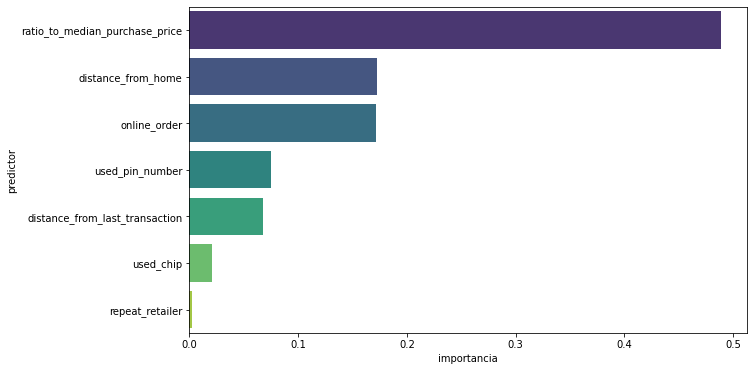

In [57]:
# Lo representamos graficamente
plt.figure(figsize=(10,6))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores, palette="viridis");
plt.show()

Podemos ver que en el *Random Forest* la importancia de el ratio del precio medio sigue siendo la variable que más afecta, sin embargo entran otras variables a tener en cuenta como si es un pedido online, se usa el pin o la distancia de la última compra. 